In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

catalog_path = "/Users/anandkrishnakumar/Coding/musicr/musicr/pipeline/trusted/data_catalog.csv"
combined_df_path = "/Users/anandkrishnakumar/Coding/musicr/musicr/pipeline/trusted/combined_wav.csv"

combined_wav_path = "/Users/anandkrishnakumar/Coding/musicr/musicr/pipeline/trusted/combined_wav/{id}.wav"

In [2]:
# Load audio file
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    return y, sr

# Get power spectrogram


def get_power_spectrogram(y, sr, log=False):
    spectrogram = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    if log:
        return librosa.amplitude_to_db(spectrogram)
    else:
        return spectrogram

# Get MFCCs


def get_mfccs(y, sr):
    mfccs = librosa.feature.mfcc(y=y, n_fft=2048, hop_length=512, n_mfcc=13)
    return mfccs

In [3]:
# Load data catalog
catalog = pd.read_csv(catalog_path)
combined_df = pd.read_csv(combined_df_path)#.iloc[:1000]

combined_df.head()

,id,instrument_1,instrument_2
0,0,keyboard_electronic_069-057-050,flute_acoustic_002-067-025
1,1,keyboard_synthetic_000-052-100,guitar_electronic_028-077-050
2,2,guitar_electronic_022-071-100,string_acoustic_014-061-127
3,3,string_acoustic_071-052-075,flute_synthetic_000-057-025
4,4,flute_synthetic_000-072-100,string_acoustic_056-050-050


In [4]:
catalog.head()

,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str
0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,['dark'],2,bass_synthetic_068-049-025,0,bass
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar
3,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,acoustic,127,reed_acoustic_037,387,16000,['reverb'],0,reed_acoustic_037-068-127,7,reed
4,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,['reverb'],0,flute_acoustic_002-077-100,2,flute


In [5]:
# Construct data
data = {"mfccs": [], "instrument_1": [], "instrument_2": []}

for index, row in combined_df.iterrows():
    file_path = combined_wav_path.format(id=row["id"])
    y, sr = load_audio(file_path)
    mfccs = get_mfccs(y, sr)
    data["mfccs"].append(mfccs)
    data["instrument_1"].append(row["instrument_1"].split("_")[0])
    data["instrument_2"].append(row["instrument_2"].split("_")[0])

In [6]:
# Construct dataframe for y
y_df = pd.DataFrame({"instrument_1": data["instrument_1"], "instrument_2": data["instrument_2"]})
y_df.head()

,instrument_1,instrument_2
0,keyboard,flute
1,keyboard,guitar
2,guitar,string
3,string,flute
4,flute,string


In [7]:
# Get unique instruments
unique_instruments = pd.concat([y_df["instrument_1"], y_df["instrument_2"]]).unique()

unique_instruments

array(['keyboard', 'guitar', 'string', 'flute'], dtype=object)

In [8]:
# Create a column for each instrument
for instrument in unique_instruments:
    y_df[instrument] = np.where((y_df["instrument_1"] == instrument) | (y_df["instrument_2"] == instrument), 1, 0)

y_df.head()

,instrument_1,instrument_2,keyboard,guitar,string,flute
0,keyboard,flute,1,0,0,1
1,keyboard,guitar,1,1,0,0
2,guitar,string,0,1,1,0
3,string,flute,0,0,1,1
4,flute,string,0,0,1,1


In [9]:
# Now we can construct input and targets
inputs = np.array(data["mfccs"])
targets = y_df[unique_instruments].values

# Split the data while getting the indices of the split
indices = np.arange(inputs.shape[0])
indices_train, indices_test = train_test_split(indices, test_size=0.3, random_state=42)

# Split the data using the indices
inputs_train, inputs_test = inputs[indices_train], inputs[indices_test]
targets_train, targets_test = targets[indices_train], targets[indices_test]

In [10]:
# Build network
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(inputs_train.shape[1], inputs_train.shape[2])),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(unique_instruments), activation='sigmoid')
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2249)              0         
                                                                 
 dense (Dense)               (None, 512)               1152000   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 1,324,740
Trainable params: 1,324,740
Non-

In [11]:
# Train model until accuracy converges

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

history = model.fit(inputs_train, targets_train, validation_data=(inputs_test, targets_test), epochs=500, batch_size=64, callbacks=[early_stopping])

Epoch 1/500


2024-02-14 22:52:17.243987: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


55/55 [==============================] - 1s 6ms/step - loss: 2.6586 - accuracy: 0.3177 - val_loss: 0.6301 - val_accuracy: 0.2947
Epoch 2/500
55/55 [==============================] - 0s 5ms/step - loss: 0.4488 - accuracy: 0.3249 - val_loss: 0.4121 - val_accuracy: 0.3313
Epoch 3/500
55/55 [==============================] - 0s 4ms/step - loss: 0.3189 - accuracy: 0.3277 - val_loss: 0.3227 - val_accuracy: 0.4260
Epoch 4/500
55/55 [==============================] - 0s 5ms/step - loss: 0.2510 - accuracy: 0.3320 - val_loss: 0.2175 - val_accuracy: 0.3693
Epoch 5/500
55/55 [==============================] - 0s 5ms/step - loss: 0.2200 - accuracy: 0.3449 - val_loss: 0.1953 - val_accuracy: 0.3633
Epoch 6/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1657 - accuracy: 0.3543 - val_loss: 0.1831 - val_accuracy: 0.4053
Epoch 7/500
55/55 [==============================] - 0s 4ms/step - loss: 0.1538 - accuracy: 0.3403 - val_loss: 0.3052 - val_accuracy: 0.3880
Epoch 8/500
55/55 [======

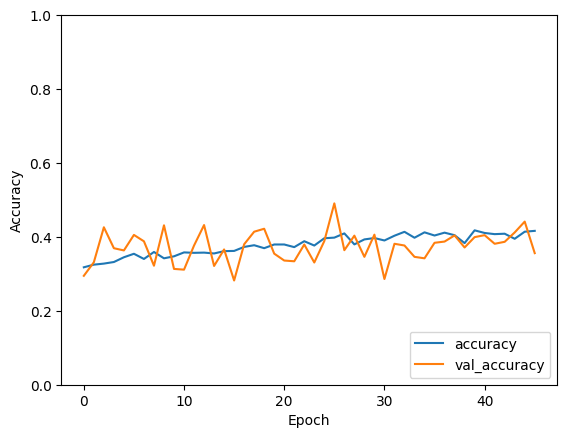

In [12]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [13]:
# Predict on test set
predictions = model.predict(inputs_test)

# Convert each prediction to 1 or 0
predictions = np.where(predictions > 0.5, 1, 0)

# Convert predictions to instrument names
predicted_instruments = []
for prediction in predictions:
    instruments = []
    for i, value in enumerate(prediction):
        if value == 1:
            instruments.append(unique_instruments[i])
    predicted_instruments.append(instruments)



47/47 [==============================] - 0s 1ms/step


In [14]:
i = 50
index = indices_test[i]

print("ith prediction:", predicted_instruments[i])

row = combined_df.iloc[index]
row

ith prediction: ['string', 'flute']


id                                     4615
instrument_1    string_acoustic_056-074-075
instrument_2     flute_acoustic_002-084-075
Name: 4615, dtype: object

In [18]:
# Testing

def get_prediction_by_id(id):
    combined_df.loc[combined_df["id"] == id]

    file_path = combined_wav_path.format(id=id)
    y, sr = load_audio(file_path)
    mfccs = get_mfccs(y, sr)
    mfccs = np.expand_dims(mfccs, axis=0)

    prediction = model.predict(mfccs)
    prediction = np.where(prediction > 0.5, 1, 0)
    instruments = []
    for i, value in enumerate(prediction[0]):
        if value == 1:
            instruments.append(unique_instruments[i])
    
    return instruments

id = 31
get_prediction_by_id(id)

1/1 [==============================] - 0s 36ms/step


['guitar', 'string']

In [1]:
import numpy as np

In [27]:
n = 100000
ys = []

# roll a die until 6 appears. if 5 appears, start over
while len(ys) < n:
    i = 0
    while True:
        i += 1
        x = np.random.randint(1, 7)
        if x == 6:
            ys.append(i)
            break
        elif x == 5:
            break

np.mean(ys)

2.9993

In [30]:
ys = []
while len(ys) < n:
    while True:
        x = np.random.randint(1, 7)
        if x != 5:
            ys.append(x)
            break
np.mean(np.array(ys, dtype=int) == 6)

0.20028

In [37]:
n = 1000000
ys = []
for i in range(n):
    y = 0
    while y < 15:
        x = np.random.randint(1, 7)
        if x == 6:
            y = 0
            break
        else:
            y += x
    ys.append(y)

In [38]:
np.mean(ys)

6.150287

In [46]:
ys = []
n = 100000

for i in range(n):
    x = 2 * np.random.randint(1, 7)
    y = np.random.randint(1, 7)
    if y%2 == 0:
        x -= 1
    ys.append(x)

In [47]:
vals, freqs = np.unique(ys, return_counts=True)
for val in vals:
    print(f"{val}: {freqs[val-1]/sum(freqs)}")

1: 0.08346
2: 0.0837
3: 0.08363
4: 0.08356
5: 0.08385
6: 0.08191
7: 0.08352
8: 0.08318
9: 0.08275
10: 0.08442
11: 0.08419
12: 0.08183


In [53]:
y = np.random.normal(0, 1, 1000)
x = np.random.normal(0, 1, 1000)

np.corrcoef(x, y)

array([[ 1.        , -0.01437431],
       [-0.01437431,  1.        ]])

In [58]:
ys = []
n = 1000000
for i in range(n):
    x = 0
    while x < 100:
        y = np.random.randint(1, 7)
        x += y
    if x == 100:
        ys.append(x-y)


In [59]:
vals, freqs = np.unique(ys, return_counts=True)
for val in vals:
    print(f"{val}: {freqs[val-94]/sum(freqs)}")

94: 0.16768584019685742
95: 0.16639072557921375
96: 0.16618420730234626
97: 0.16552264875441478
98: 0.16697877762181954
99: 0.16723780054534826


In [62]:
y = 1
for i in range(1, 101):
    y *= (2001 - i)/2000

In [63]:
y

0.08069358414212661

In [76]:
n = 10000
ys = []
for i in range(n):
    xs = []
    while(len(xs) == len(set(xs))):
        xs.append(np.random.randint(1, 20001))
    ys.append(len(xs)-1)

In [77]:
np.mean(ys)

178.592

In [87]:
import math

y = 0
for k in range(1, 2001):
    x = 1
    for i in range(0, k):
        x *= (2000-i)/2000
    y += x

In [34]:
ys = []
n = 100000
for _ in range(n):
    i = 2
    x = np.random.randint(1, 7)
    y = np.random.randint(1, 7)
    cons = (x == 6) and (y == 6)
    while (i < 10) and (not cons):
        i += 1
        x = y
        y = np.random.randint(1, 7)
        cons = ((x == 6) and (y == 6))
    ys.append(cons)


np.mean(ys)

0.20115

In [30]:
n = 9
6 * (1 - (5/6)**n)

4.83715980319311

In [36]:
M = np.array([
    [5/6, 1/6, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [5/6, 0, 1/6, 0, 0, 0, 0, 0, 0, 0, 0],
    [5/6, 0, 0, 1/6, 0, 0, 0, 0, 0, 0, 0],
    [5/6, 0, 0, 0, 1/6, 0, 0, 0, 0, 0, 0],
    [5/6, 0, 0, 0, 0, 1/6, 0, 0, 0, 0, 0],
    [5/6, 0, 0, 0, 0, 0, 1/6, 0, 0, 0, 0],
    [5/6, 0, 0, 0, 0, 0, 0, 1/6, 0, 0, 0],
    [5/6, 0, 0, 0, 0, 0, 0, 0, 1/6, 0, 0],
    [5/6, 0, 0, 0, 0, 0, 0, 0, 0, 1/6, 0],
    [5/6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1/6],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
])

np.power(M, 100)[0]

array([1.20746735e-08, 1.53064671e-78, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])